<a href="https://colab.research.google.com/github/pipeton8/6.864-advanced-nlp/blob/main/Assignments/Assignment%202/hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%bash
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit 
rm -rf hw2
git clone https://github.com/mit-6864/hw2.git

Cloning into 'hw2'...


In [37]:
import sys
sys.path.append("/content/hw2")

import csv
import itertools as it
import numpy as np
import sklearn.decomposition
np.random.seed(0)
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import lab_util

# Introduction

In this notebook, you will find code scaffolding for the implementation portion of Homework 2. There are certain parts of the scaffolding marked with `# Your code here!` comments where you can fill in code to perform the specified tasks. After implementing the methods in this notebook, you will need to design and perform experiments to evaluate each method and respond to the questions in the Homework 2 handout (available on Canvas). You should be able to complete this assignment without changing any of the scaffolding code, just writing code to fill in the scaffolding and run experiments.

## Dataset

We're going to be working with a dataset of product reviews. The following cell loads the dataset and splits it into training, validation, and test sets.

In [3]:
data = []
n_positive = 0
n_disp = 0

with open("/content/hw2/reviews.csv") as reader:
  csvreader = csv.reader(reader)
  next(csvreader)
  for id, review, label in csvreader:
    label = int(label)

    # hacky class balancing
    if label == 1:
      if n_positive == 2000:
        continue

      n_positive += 1

    if len(data) == 4000:
      break

    data.append((review, label))
    
    if n_disp > 5:
      continue

    n_disp += 1

    print("review:", review)
    print("rating:", label, "(good)" if label == 1 else "(bad)")
    print()

print(f"Read {len(data)} total reviews.")

# Shuffle before splitting
np.random.shuffle(data)
reviews, labels = zip(*data)

# Training (3000 samples)
train_reviews = reviews[:3000]
train_labels = labels[:3000]

# Validation (500 samples)
val_reviews = reviews[3000:3500]
val_labels = labels[3000:3500]

# Testing (500 samples)
test_reviews = reviews[3500:]
test_labels = labels[3500:]

review: I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.
rating: 1 (good)

review: Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".
rating: 0 (bad)

review: This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar.  And it is a tiny mouthful of heaven.  Not too chewy, and very flavorful.  I highly recommend this yummy treat.  If you are familiar with the story of C.S. Lewis' "The Lion, The Witch, and The Wardrobe" - this is the treat that seduces Edmund into selling out his Brother an

# Part 1: word representations via matrix factorization

First, we'll construct the term-document matrix (look at `/content/hw2/lab_util.py` in the file browser on the left if you want to see how this works).

In [4]:
vectorizer = lab_util.CountVectorizer()
vectorizer.fit(train_reviews)
td_matrix = vectorizer.transform(train_reviews).T
print(f"TD matrix is {td_matrix.shape[0]} x {td_matrix.shape[1]}")

TD matrix is 2006 x 3000


First, implement the function `learn_reps_lsa` that computes word representations via latent semantic analysis. The `sklearn.decomposition` or `np.linalg` packages may be useful.

In [29]:
print(a)
b = a.max(axis=1,keepdims=True)
print(b)
print(a/b)

[[0 1]
 [2 3]]
[[1]
 [3]]
[[0.         1.        ]
 [0.66666667 1.        ]]


In [62]:
def idf_matrix(matrix, idf_weight = 'idf'):
  """ Given a |V| x n TD matrix, returns the |V| IDF vector associated, where
      idf(w) = log (# documents / # documents that contain w)
  """
  reviews_per_word = np.sum(matrix > 0, axis=1, keepdims=True)
  reviews = matrix.shape[1]

  if idf_weight == 'idf':
    return np.log(reviews/(1+reviews_per_word))

def tf_matrix(matrix, tf_weight = 'raw'):
  """
    Given a |V| x n TD matrix, returns the |V| x n tf matrix, weighted according
    to tf_weight.
  """

  if tf_weight == 'raw':
    tf_matrix = matrix

  elif tf_weight == 'term frequency':
    tf_matrix = matrix/matrix.sum()

  elif tf_weight == 'log normalization':
    tf_matrix = np.log(1+matrix)

  elif tf_weight.find('double') != -1:
    try:
      k = int(tf_weight[-1])
      tf_matrix =  k + (1-k) * matrix/matrix.max(axis=0,keepdims=True)
    except:
      print("Double-k misspecified, raw weight applied")
      tf_matrix = matrix

  return tf_matrix

def learn_reps_lsa(matrix, rep_size, tf_weight='raw', tf_idf=False, idf_weight='idf'):
    # `matrix` is a `|V| x n` matrix (usually a TD matrix), 
    # where `|V|` is the number of words in the vocabulary and `n`
    # is the number of reviews in the (training) corpus.
    # This function should return a `|V| x rep_size` matrix with each
    # row corresponding to a word representation.
    
    LSA_matrix = tf_matrix(matrix,tf_weight)

    if tf_idf:
      # Get IDF vector
      idf = idf_matrix(matrix, idf_weight)

      # Compute TF-IDF matrix
      LSA_matrix = LSA_matrix * idf

    # Initialize svd object
    svd = sklearn.decomposition.TruncatedSVD(n_components=rep_size)

    # Decompose TF-IDF matrix
    return svd.fit_transform(LSA_matrix)

Let's look at some representations:

In [7]:
words = ["good", "bad", "cookie", "jelly", "dog", "the", "3"]
show_tokens = [vectorizer.tokenizer.word_to_token[word] for word in words]

In [8]:
reps = learn_reps_lsa(td_matrix, 500)
lab_util.show_similar_words(vectorizer.tokenizer, reps, show_tokens)

good 47
  . 1.056
  a 1.101
  but 1.121
  , 1.152
  the 1.157
bad 201
  . 1.396
  taste 1.416
  but 1.434
  a 1.435
  i 1.449
cookie 504
  nana's 0.777
  cookies 1.036
  oreos 1.287
  bars 1.362
  bites 1.425
jelly 351
  twist 1.144
  cardboard 1.230
  advertised 1.382
  peanuts 1.406
  plastic 1.454
dog 925
  food 1.048
  pet 1.069
  pets 1.071
  switched 1.208
  foods 1.230
the 36
  . 0.331
  <unk> 0.366
  of 0.395
  and 0.403
  to 0.422
3 289
  8 1.210
  . 1.239
  the 1.271
  to 1.272
  <unk> 1.279


We've been operating on the raw count matrix, but in class we discussed several reweighting schemes aimed at making LSA representations more informative. 

Here, implement the TF-IDF transform and see how it affects learned representations. While it is okay (and in fact encouraged) to use vectorized numpy operations, you should refrain from using pre-implemented library functions for computing TF-IDF.

How does TF-IDF normalization change the learned similarity function?

In [33]:
reps_tfidf = learn_reps_lsa(td_matrix, 500, tf_idf=True)
lab_util.show_similar_words(vectorizer.tokenizer, reps_tfidf, show_tokens)

good 47
  . 0.981
  but 1.013
  a 1.030
  and 1.087
  is 1.090
bad 201
  . 1.329
  taste 1.340
  but 1.361
  a 1.372
  not 1.380
cookie 504
  nana's 0.811
  cookies 1.145
  moist 1.437
  bars 1.438
  oreos 1.451
jelly 351
  twist 1.100
  cardboard 1.233
  advertised 1.307
  plastic 1.506
  plum 1.512
dog 925
  food 1.031
  pets 1.097
  pet 1.102
  foods 1.192
  switched 1.250
the 36
  . 0.212
  and 0.269
  <unk> 0.291
  of 0.303
  to 0.323
3 289
  8 1.143
  . 1.173
  to 1.220
  the 1.220
  of 1.234


Now that we have some representations, let's see if we can do something useful with them.

Below, implement a feature function that represents a document as the sum of its
learned word embeddings.

The remaining code trains a logistic regression model on a set of *labeled* reviews; we're interested in seeing how much representations learned from *unlabeled* reviews improve classification.

(Note: the staff solutions for each of the three featurizers achieve accuracies of between .78 and .83 with the full training corpus (3000 examples).)

In [63]:
import sklearn.linear_model

def word_featurizer(xs):
    # normalize
    return xs / np.sqrt((xs ** 2).sum(axis=1, keepdims=True))

def lsa_featurizer(xs, reps):
    # This function takes in a `|D| x |V|` TD matrix in which each row contains
    # the word counts for the given review.
    # It should return a matrix where each row contains the learned feature
    # representation of each review (e.g. the sum of LSA word representations).
    # (Hint: use TF-IDF LSA features, which should be a global variable after
    # running the previous cell; no need to pass it in as an argument.)
    feats = np.zeros((xs.shape[0],reps.shape[1]))
    idf = idf_matrix(xs.T, 'idf')

    for i in range(xs.shape[0]):
      doc_wordCount = (xs[i,:] > 0).T.reshape((-1,1))
      feats[i,:] = np.sum(doc_wordCount * idf * reps,axis=0, keepdims=True)

    # normalize
    return feats / np.sqrt((feats ** 2).sum(axis=1, keepdims=True))

# We've implemented the remainder of the training and evaluation pipeline,
# so you likely won't need to modify the following four functions.
def combo_featurizer(xs, reps):
    return np.concatenate((word_featurizer(xs), lsa_featurizer(xs, reps)), axis=1)

def train_model(xs, ys, featurizer, reps = None):
    if reps is None:
      xs_featurized = featurizer(xs)
    else:
      xs_featurized = featurizer(xs, reps)

    model = sklearn.linear_model.LogisticRegression()
    model.fit(xs_featurized, ys)

    return model

def eval_model(model, xs, ys, featurizer, reps=None):
    if reps is None:
      xs_featurized = featurizer(xs)
    else:
      xs_featurized = featurizer(xs, reps)

    pred_ys = model.predict(xs_featurized)

    return np.mean(pred_ys == ys)

def training_experiment(name, n_train, featurizer, reps=None, verbose=True):
    if verbose:
      print(f"{name} features, {n_train} examples")

    train_xs = vectorizer.transform(train_reviews[:n_train])
    train_ys = train_labels[:n_train]
    test_xs = vectorizer.transform(test_reviews)
    test_ys = test_labels
    model = train_model(train_xs, train_ys, featurizer, reps)
    acc = eval_model(model, test_xs, test_ys, featurizer, reps)

    if verbose:
      print(f"Accuracy is {acc*100:.2f}%")
      print("")

    return acc

# The following four lines will run a training experiment with all 3k examples
# in training set for each feature type. `training_experiment` may be useful to
# you when performing experiments to answer questions in the handout.
n_train = 3000
embed_size = 500

reps_tfidf = learn_reps_lsa(td_matrix, embed_size, tf_idf=True)
acc = training_experiment("word", n_train, word_featurizer)
acc = training_experiment("lsa", n_train, lsa_featurizer, reps=reps_tfidf)
acc = training_experiment("combo", n_train, combo_featurizer, reps=reps_tfidf)
print()

word features, 3000 examples
Accuracy is 78.40%

lsa features, 3000 examples
Accuracy is 81.00%

combo features, 3000 examples
Accuracy is 82.40%




**Part 1: Lab writeup**

Part 1 of your lab report should discuss any implementation details that were important to filling out the code above, as well as your answers to the questions in Part 1 of the Homework 2 handout. Below, you can set up and perform experiments that answer these questions (include figures, plots, and tables in your write-up as you see fit).

## Experiments for Part 1

In [64]:
# The following four lines will run a training experiment with all 3k examples
# in training set for each feature type. `training_experiment` may be useful to
# you when performing experiments to answer questions in the handout.
n_train = 3000
embed_sizes = [100*i for i in range(1,11)]
accs = {'word'  : [],
        'lsa'   : [],
        'combo' : []
        }

features = ['word', 'lsa', 'combo']
featurizers = [word_featurizer, lsa_featurizer, combo_featurizer]

for embed_size in tqdm(embed_sizes):
  reps = learn_reps_lsa(td_matrix, embed_size, tf_weight='term frequency', tf_idf=True)
  # print(f"Using embedding size of {embed_size} dimensions.")
  # print("-"*40)

  for feature,featurizer in zip(features,featurizers):
    if feature == 'word':
      accs[feature].append(training_experiment(feature, n_train, featurizer, verbose =False))
    else:
      accs[feature].append(training_experiment(feature, n_train, featurizer,reps, verbose=False))

  0%|          | 0/10 [00:00<?, ?it/s]

In [69]:
print("Max accuracies:")
for feature in features:
  print(" "*3 + f"{feature}: {sorted(accs[feature])[-1]*100:.2f}%")

Max accuracies:
   word: 78.40%
   lsa: 80.80%
   combo: 82.40%


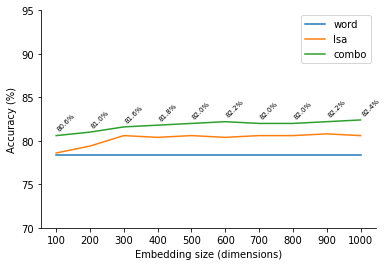

In [110]:
offset = (0,0.5)
fig, ax = plt.subplots()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for feature in features:
  x = embed_sizes
  y = [acc*100 for acc in accs[feature]]
  sns.lineplot(x=x, y=y, label=feature, ax=ax)

  if feature == 'combo':
    for x_i,y_i in zip(x,y):
      s = f'{y_i:.1f}%'
      ax.text(x=x_i+offset[0], 
              y=y_i+offset[1],
              rotation=45,
              fontsize=7,
              s=s)

  plt.yticks([70 + 5*x for x in range(6)])
  plt.ylabel("Accuracy (%)")
  plt.xticks(embed_sizes)
  plt.xlabel("Embedding size (dimensions)")

## Part 2: word representations via language modeling

In this section, we'll train a word embedding model with a word2vec-style objective rather than a matrix factorization objective. This requires a little more work; we've provided scaffolding for a PyTorch model implementation below.
If you don't have much PyTorch experience, there are some tutorials [here](https://pytorch.org/tutorials/) which may be useful. You're also welcome to implement these experiments in any other framework of your choosing (note that we won't be able to provide debugging support if you use a different framework).

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as torch_data

class Word2VecModel(nn.Module):
    # A torch module implementing a word2vec predictor. The `forward` function
    # should take a batch of context word ids as input and predict the word 
    # in the middle of the context as output, as in the CBOW model from lecture.
    # Hint: look at how padding is handled in lab_util.get_ngrams when
    # initializing `ctx`: vocab_size is used as the padding token for contexts
    # near the beginning and end of sequences. If you use an embedding module
    # in your Word2Vec implementation, make sure to account for this extra
    # padding token, and account for it with the `padding_idx` kwarg.

    def __init__(self, vocab_size, embed_dim, padding_idx=2006):
        super().__init__()

        self.embed_dim = embed_dim
        self.vocab_size = vocab_size
        self.padding_idx = padding_idx

    def forward(self, context):
        # Context is an `n_batch x vocab_size` matrix of integer word ids
        # this function should return an `n_batch x vocab_size` matrix with
        # element i, j being the (possibly log) probability of the middle word
        # in context i being word j.

        # Your code here!
        raise NotImplementedError

In [ ]:
def learn_reps_word2vec(corpus, window_size, rep_size, n_epochs, n_batch):
    #This method takes in a corpus of training sentences. It returns a matrix of
    # word embeddings with the same structure as used in the previous section of 
    # the assignment. (You can extract this matrix from the parameters of the 
    # Word2VecModel.)

    tokenizer = lab_util.Tokenizer()
    tokenizer.fit(corpus)
    tokenized_corpus = tokenizer.tokenize(corpus)

    ngrams = lab_util.get_ngrams(tokenized_corpus, window_size, pad_idx=2006)

    device = torch.device('cuda')  # run on colab gpu
    model = Word2VecModel(tokenizer.vocab_size, rep_size).to(device)
    opt = optim.Adam(model.parameters(), lr=0.001)

    loader = torch_data.DataLoader(ngrams, batch_size=n_batch, shuffle=True)

    # What loss function should we use for Word2Vec?
    loss_fn = None  # Your code here!

    losses = []  # Potentially useful for debugging (loss should go down!)
    for epoch in tqdm(range(n_epochs)):
        epoch_loss = 0
        for context, label in loader:
            # As described above, `context` is a batch of context word ids, and
            # `label` is a batch of predicted word labels.

            # Here, perform a forward pass to compute predictions for the model.
            # Your code here!
            preds = None


            # Now finish the backward pass and gradient update.
            # Remember, you need to compute the loss, zero the gradients
            # of the model parameters, perform the backward pass, and
            # update the model parameters.
            # Your code here!
            loss = None


            epoch_loss += loss.item()
        losses.append(epoch_loss)

    # Hint: you want to return a `vocab_size x embedding_size` numpy array
    embedding_matrix = None  # Your code here!

    return embedding_matrix

In [ ]:
# Use the function you just wrote to learn Word2Vec embeddings:
reps_word2vec = learn_reps_word2vec(train_reviews, 2, 500, 10, 100)

After training the embeddings, we can try to visualize the embedding space to see if it makes sense. First, we can take any word in the space and check its closest neighbors.

In [ ]:
lab_util.show_similar_words(vectorizer.tokenizer, reps_word2vec, show_tokens)

We can also cluster the embedding space. Clustering in 4 or more dimensions is hard to visualize, and even clustering in 2 or 3 can be difficult because there are so many words in the vocabulary. One thing we can try to do is assign cluster labels and qualitiatively look for an underlying pattern in the clusters.

In [ ]:
from sklearn.cluster import KMeans

indices = KMeans(n_clusters=10).fit_predict(reps_word2vec)
zipped = list(zip(range(vectorizer.tokenizer.vocab_size), indices))
np.random.shuffle(zipped)
zipped = zipped[:100]
zipped = sorted(zipped, key=lambda x: x[1], reverse=True)
for token, cluster_idx in zipped:
    word = vectorizer.tokenizer.token_to_word[token]
    print(f"{word}: {cluster_idx}")

Finally, we can use the trained word embeddings to construct vector representations of full reviews. One common approach is to simply average all the word embeddings in the review to create an overall embedding. Implement the transform function in Word2VecFeaturizer to do this.

In [ ]:
def w2v_featurizer(xs):
    # This function takes in a matrix in which each row contains the word counts
    # for the given review. It should return a matrix in which each row contains
    # the average Word2Vec embedding of each review (hint: this will be very
    # similar to `lsa_featurizer` from above, just using Word2Vec embeddings 
    # instead of LSA).

    feats = None # Your code here!

    # normalize
    return feats / np.sqrt((feats ** 2).sum(axis=1, keepdims=True))

training_experiment("word2vec", w2v_featurizer, 3000)
print()

**Part 2: Lab writeup**

Part 2 of your lab report should discuss any implementation details that were important to filling out the code above, as well as your answers to the questions in Part 2 of the Homework 2 handout. Below, you can set up and perform experiments that answer these questions (include figures, plots, and tables in your write-up as you see fit).

## Experiments for Part 2

In [ ]:
# Your code here!

# Part 3 (6.864 only)

In Part 3, you will extend the methods you've implemented in Parts 1 and 2 with the goal of improving final predictive performance. You should experiment with at least one idea to improve the model --- feel free to focus on either the featurizer or the classifier. Some suggestions of things you could try:

1. Implement a different TD matrix normalization method (see lecture slides for alternatives to TF-IDF).
2. Implement a different Word2Vec formulation (in Part 2, you implemented the CBOW formulation; does the skip-gram formulation perform any better?).
3. Implement a more sophisticated classifier module.
4. Tune featurizer and/or classifier hyperparameters (for full marks, you should obtain at least a 1% improvement in prediction accuracy if you only tune hyperparameters).

In your report, discuss what you implemented (including relevant design decisions), and how your change(s) impacted performance.

Note: As long as you try something with difficulty comparable to the suggested modifications and have a meaningful discussion of your results in your report, you can earn full marks (you do not necessarily need to improve performance).

In [ ]:
# Your code here!